In [2]:
import arviz as az
import pymc3 as pm
# import arviz.labels as azl

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import matplotlib as mpl
import warnings
import functions as funcs
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
def R(x):
    return 1/x

In [4]:
features = ['dihedrals', 'distances_linear', 'distances_logistic']
feature_names = ['Dihedrals', 'Distances', 'logistic(Distances)']

inp_dir = 'sensitivities_exp_log_outcome'


In [5]:
relevance_vars = ["l_tica__lag_s","l_tica__dim_s", "l_cluster__k_s", "l_distances__centre_s", "l_distances__steepness_s"]


info_share_vars =["l_distances__scheme[closest-heavy]_s", "l_distances__scheme[ca]_s"]




In [6]:
def make_labeller(labels):
    var_name_map={"l_cluster__k_s": r"$n$", 
                "l_tica__dim_s": r"$m$", 
                "l_tica__lag_s": r"$\tau_{tICA}$",
                "l_distances__scheme[closest-heavy]_s": "$X-X$", 
                "l_distances__scheme[ca]_s": r"$C\alpha-C\alpha$", 
                 "l_distances__centre_s": r"$cent.$", 
                 "l_distances__steepness_s": r"$steep.$"}
                  
    def labeller(pos, x):
        label = labels[x]
        old_text = label.get_text()

        if '__' in old_text:
            var = old_text.split(':')[-1].strip()
            new_var = var_name_map[var]
            new_txt = f"{old_text.split(':')[0]} : {new_var}" 
        else:
            new_txt = old_text
        return new_txt
    
    return labeller


def get_model_names(paths):
    model_names = []
    for x in paths:
        text = np.array(str(x.stem).split('_'))
        outcome_ix = np.where((text=='timescale') | (text == 'vamp'))[0][0]
        outcome = text[outcome_ix]
        if outcome == 'timescale':
            num_its = text[outcome_ix+2]
            outcome = f'$t_{{{num_its}}}$'
        if outcome == 'vamp':
            outcome = outcome.upper()
        model_names.append(outcome) 
    return model_names

def get_traces(paths):
    all_models = [pickle.load(x.open('rb')) for x in paths]
    all_traces = [x['trace'] for x in all_models]
    all_traces = [az.from_pymc3(trace=x)['posterior'] for x in all_traces]    
    return all_traces


def add_null_variables(trace, var_names):

    for var_name in var_names:
        trace = trace.assign({var_name: lambda x: x.sigma_n*0})
    return trace
        
    
def add_variables_to_traces(traces, all_var_names):
    tmp = []
    for trace in traces: 
        var_names = set([x for x in trace.data_vars.keys()])
        missing_vars = list(set(all_var_names) - var_names)
        trace = add_null_variables(trace, missing_vars)
        tmp.append(trace)
    return tmp
        
        

/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/var/folders/b1/0b53wj0509376104__2tttb00000gn/T/ipykernel_6507/2503918712.py:69: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale('log')
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/var/folders/b1/0b53wj0509376104__2tttb00000gn/T/ipykernel_6507/2503918712.py:69: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale('log')
/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-

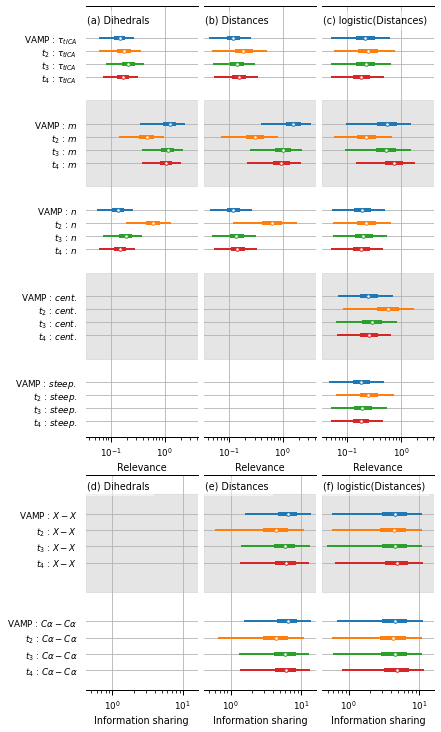

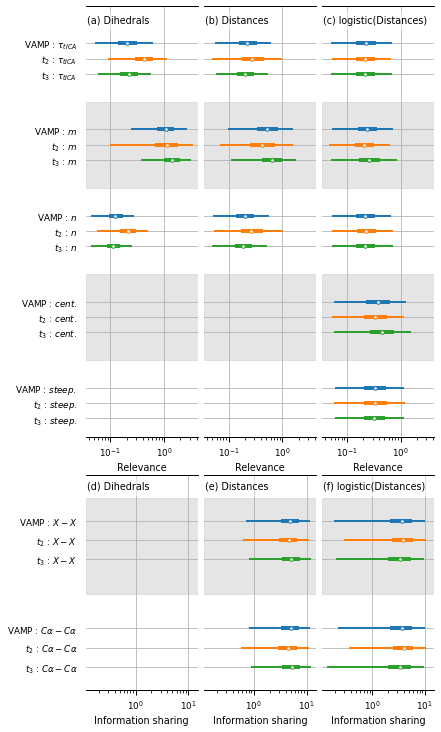

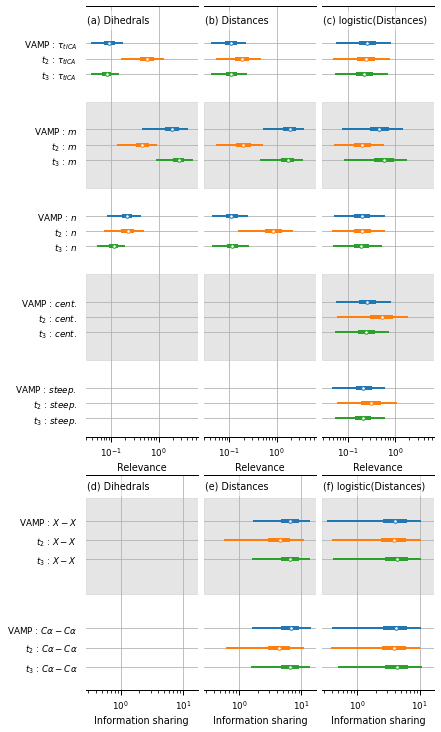

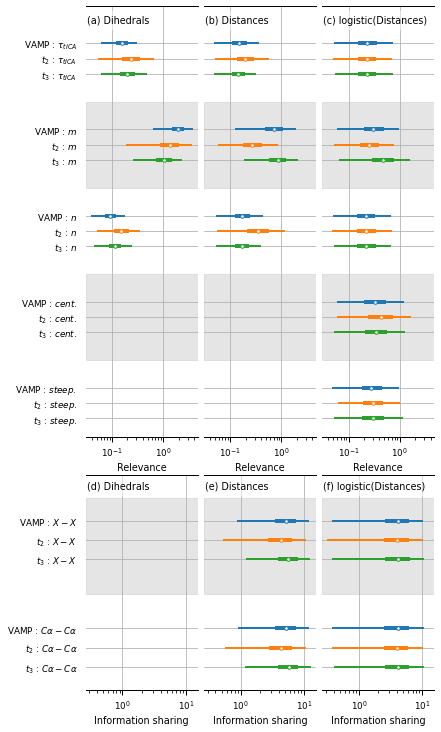

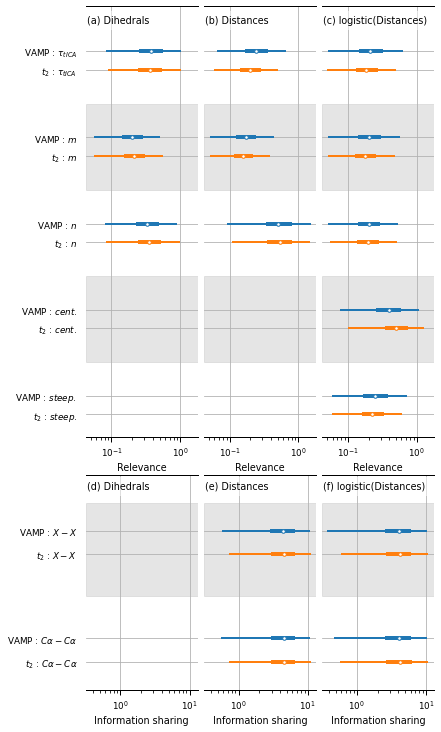

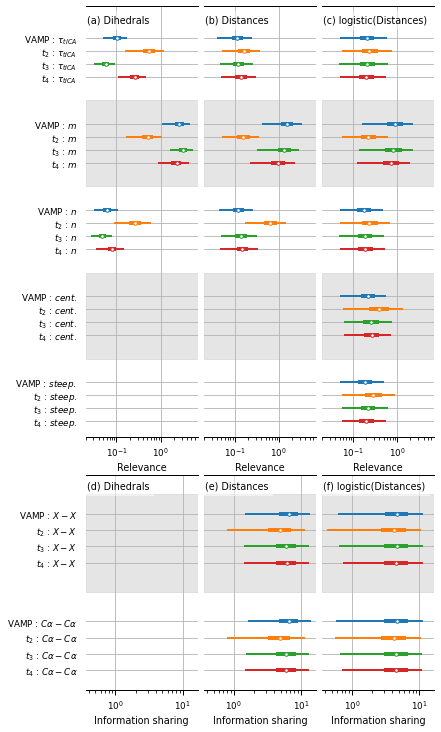

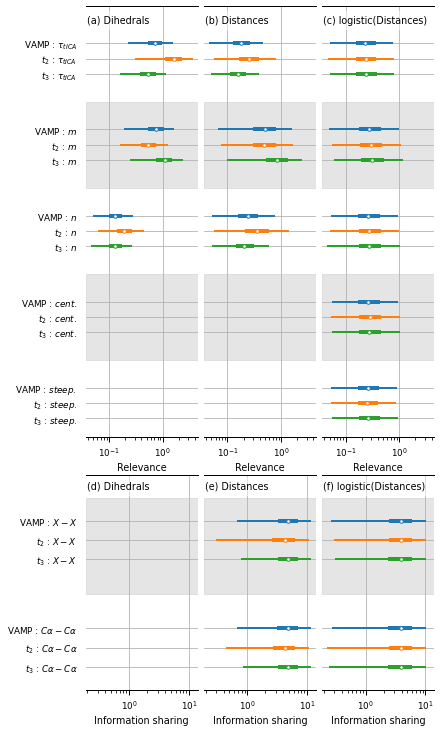

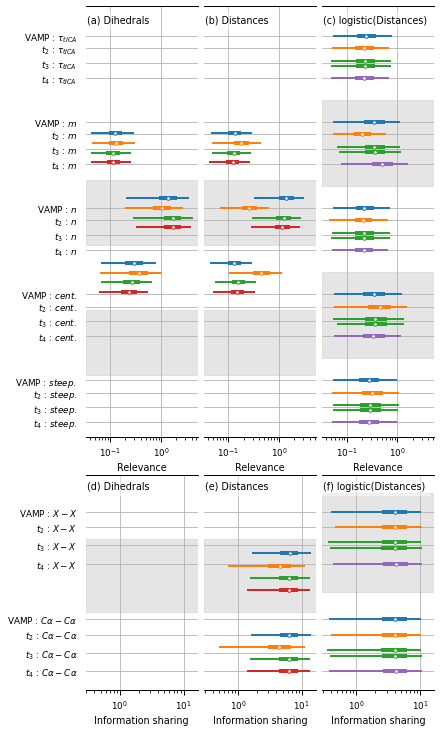

In [7]:
for protein in funcs.PROTEIN_DIRS[:8]:
    with sns.plotting_context('paper', font_scale=1):
        
        annotate_kws = dict(xycoords='axes fraction', va='top', ha='left', 
                    bbox={'facecolor': 'w', 'alpha': 0.5, 'edgecolor': 'w'})
        
        fig = plt.figure(constrained_layout=True, figsize=(6, 10))
        widths = [1, 1, 1]
        heights = [4, 2]
        spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths,
                                  height_ratios=heights)
        
        axes = np.empty((len(heights), len(widths)), dtype=object)
        for i in range(len(heights)):
            for j in range(len(widths)):
                if j > 0:
                    axes[i, j] = fig.add_subplot(spec[i, j], sharey=axes[i, 0], sharex=axes[i, 0])
                    plt.setp(axes[i, j].get_yticklabels(), visible=False)
                if j == 0: 
                    axes[i,j] = fig.add_subplot(spec[i, j])
                    
        
        for feat_ix, feature in enumerate(features):
            
            # Get the paths
            timescale_paths = list(Path(inp_dir).glob(f"{protein}_{feature}_timescale_its*"))
            timescale_paths.sort()
            vamp_path = list(Path(inp_dir).glob(f"{protein}_{feature}_vamp_sensitivity*.pkl"))[0]
            all_model_paths = [vamp_path]+timescale_paths

            if len(timescale_paths) > 0:
                
#                 print(protein, feature)
                # Get model names
                model_names = get_model_names(all_model_paths)
                all_traces = get_traces(all_model_paths)
                
                
                vars_to_add = relevance_vars+info_share_vars
                all_traces = add_variables_to_traces(all_traces, vars_to_add)
                
                # Plot relevances: 
                ax = axes[0, feat_ix]
                pm.plot_forest(all_traces, model_names=model_names, 
                               combined=True, linewidth=2, 
                       var_names=relevance_vars, transform=R, ax=ax, hdi_prob=0.95)
                ax.grid()
                ax.set_title(None)
                ax.set_xlabel("Relevance")
                ax.annotate(text=f"({funcs.LETTERS[feat_ix]}) {feature_names[feat_ix]}",xy=(0.01, 0.98), **annotate_kws)
                ax.set_xscale('log')
                
                # Adjust axes labels
                if feat_ix == 2:
                    labels = axes[0, 0].yaxis.get_majorticklabels()
                    labeller = make_labeller(labels)
                    ax.yaxis.set_major_formatter(labeller)
                
                
                # Plot infor sharing: 
                ax = axes[1, feat_ix]
                pm.plot_forest(all_traces, model_names=model_names, 
                               combined=True, linewidth=2, 
                       var_names=info_share_vars, ax=ax, hdi_prob=0.95)
                ax.grid()
                ax.set_xlabel("Information sharing")
                ax.annotate(text=f"({funcs.LETTERS[feat_ix+len(features)]}) {feature_names[feat_ix]}",xy=(0.01, 0.97),  **annotate_kws)
                ax.set_title(None)
                ax.set_xscale('log')

                # Plot information sharing
                
                # Adjust axes labels
                if feat_ix == 2:
                    labels = axes[1, 0].yaxis.get_majorticklabels()
                    labeller = make_labeller(labels)
                    ax.yaxis.set_major_formatter(labeller)                

#         plt.tight_layout()
        plt.savefig(funcs.FIG_DIR.joinpath(f'sensitivities/{protein}_sensitivity.pdf'), bbox_inches='tight')